In [150]:
## Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout, GRU, Bidirectional

import yfinance as yf
import seaborn as sns


## Load data

In [142]:
msft_ticker = yf.Ticker("MSFT")
msft_data = msft_ticker.history(start="2000-01-01", end="2023-11-05", interval="1d")


In [147]:
msft_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,36.457965,36.846228,34.788430,36.205593,53228400,0.0,0.0
2000-01-04 00:00:00-05:00,35.273765,36.380316,34.866088,34.982567,54119000,0.0,0.0
2000-01-05 00:00:00-05:00,34.516647,36.147354,33.973077,35.351414,64059600,0.0,0.0
2000-01-06 00:00:00-05:00,34.846687,35.370843,33.662482,34.167225,54976600,0.0,0.0
2000-01-07 00:00:00-05:00,33.740119,34.866084,33.332442,34.613712,62013600,0.0,0.0


In [148]:
# check null
msft_data.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [157]:
msft_data[['Open','High']].head()

,Open,High
Date,,
2000-01-03 00:00:00-05:00,36.457965,36.846228
2000-01-04 00:00:00-05:00,35.273765,36.380316
2000-01-05 00:00:00-05:00,34.516647,36.147354
2000-01-06 00:00:00-05:00,34.846687,35.370843
2000-01-07 00:00:00-05:00,33.740119,34.866084


## Data Visualization

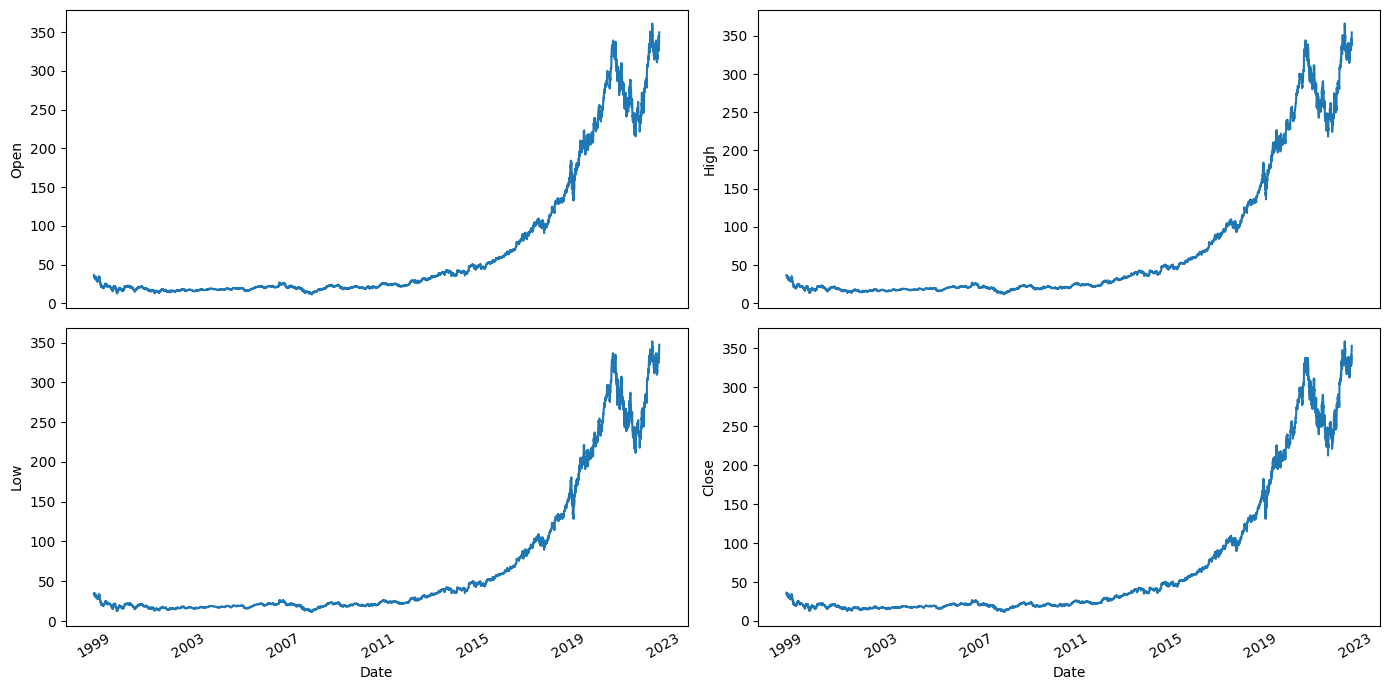

In [159]:
# Plot line charts
df_plot = msft_data[['Open','High','Low','Close']].copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [162]:
msft_close = msft_data[['Close']].copy()

scaler = MinMaxScaler()
msft_close_scaled = pd.DataFrame(scaler.fit_transform(msft_close)).rename(columns={0:"Close"})

msft_close_scaled.index = msft_close.index


In [164]:
msft_close_scaled.head()

,Close
Date,
2000-01-03 00:00:00-05:00,0.071611
2000-01-04 00:00:00-05:00,0.068091
2000-01-05 00:00:00-05:00,0.069153
2000-01-06 00:00:00-05:00,0.065744
2000-01-07 00:00:00-05:00,0.067029


In [166]:

training_size = round((msft_close_scaled.shape[0]*0.1)*8)
validation_size = round((msft_close_scaled.shape[0]*0.1)*9)
test_size = round((msft_close_scaled.shape[0]))
print(training_size,validation_size-training_size,test_size-validation_size)

4799 600 600


In [172]:
msft_close_scaled[:2]

,Close
Date,
2000-01-03 00:00:00-05:00,0.071611
2000-01-04 00:00:00-05:00,0.068091


In [171]:
msft_close_scaled[1:2]

,Close
Date,
2000-01-04 00:00:00-05:00,0.068091


In [173]:
data_training = msft_close_scaled[:training_size]
data_validation = msft_close_scaled[training_size:validation_size]
data_test = msft_close_scaled[validation_size:test_size]

In [174]:
print(data_training.shape[0], data_validation.shape[0], data_test.shape[0])

4799 600 600


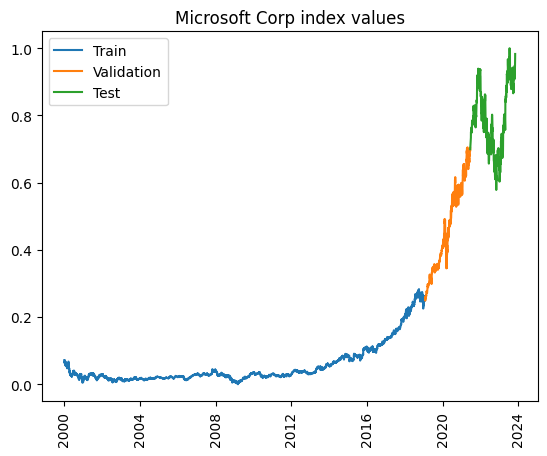

In [179]:
plt.plot(data_training.index, data_training)
plt.plot(data_validation.index, data_validation)
plt.plot(data_test.index, data_test)
plt.title("Microsoft Corp index values")
plt.xticks(rotation=90)
plt.legend(['Train', 'Validation', 'Test'])

In [72]:
def create_data(data, time_step):

    sliding_data = []

    for index in range(len(data) - time_step):
        sliding_data.append(data[index: index + time_step])

    sliding_data = np.array(sliding_data)

    x_data = sliding_data.reshape(-1,time_step, 1)
    #y_data = sliding_data[:, -1].reshape(-1,1)
    y_data = data[time_step:].reshape(-1,1)

    return x_data, y_data

In [73]:
x_train, y_train = create_data(data_training, 20)
x_val, y_val = create_data(data_validation, 20)
x_test, y_test = create_data(data_test, 20)

In [79]:
# Function to print RMSE figures for models
def print_error(y_train, y_test, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    


In [80]:
# Function for Plotting Loss vs Epochs
def loss_epoch(history):
    plt.figure(figsize =(10,7))
    plt.plot(history.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title("Simple RNN model, Loss vs Epoch")
    plt.show()

In [81]:
# Function for Plotting Accuracy vs Epochs
def MAE_epoch(history):
    plt.figure(figsize =(10,7))
    plt.plot(history.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracies")
    plt.title("Simple RNN model, MAE vs Epoch")
    plt.show()

In [82]:
#  Function to Plot the result
def plot_result(y_train, y_test, train_predict, test_predict):
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 10), dpi=80)
    plt.plot(range(rows), actual, c = "b")
    plt.plot(range(rows), predictions, c = "r")
    plt.axvline(x=len(y_train), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Open Values scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


In [76]:
def vanilla_RNN (hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(units = hidden_units, input_shape = input_shape, activation = activation[0]))
    model.add(Dense(units = dense_units, activation = activation[1]))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics=tf.keras.metrics.MeanAbsoluteError())
    return model

In [77]:
model = vanilla_RNN(hidden_units=1, dense_units=1, input_shape=(20,1), 
                   activation=['tanh', 'tanh'])
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=10, batch_size=20, verbose=2)

Epoch 1/10
239/239 - 6s - loss: 0.0630 - mean_absolute_error: 0.1735 - val_loss: 1.9118 - val_mean_absolute_error: 1.3768 - 6s/epoch - 24ms/step
Epoch 2/10
239/239 - 2s - loss: 0.0153 - mean_absolute_error: 0.0872 - val_loss: 1.2696 - val_mean_absolute_error: 1.1187 - 2s/epoch - 8ms/step
Epoch 3/10
239/239 - 2s - loss: 0.0062 - mean_absolute_error: 0.0567 - val_loss: 0.6350 - val_mean_absolute_error: 0.7897 - 2s/epoch - 10ms/step
Epoch 4/10
239/239 - 2s - loss: 0.0027 - mean_absolute_error: 0.0370 - val_loss: 0.2739 - val_mean_absolute_error: 0.5178 - 2s/epoch - 8ms/step
Epoch 5/10
239/239 - 2s - loss: 9.6849e-04 - mean_absolute_error: 0.0219 - val_loss: 0.1427 - val_mean_absolute_error: 0.3715 - 2s/epoch - 9ms/step
Epoch 6/10
239/239 - 2s - loss: 2.5486e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0961 - val_mean_absolute_error: 0.3023 - 2s/epoch - 9ms/step
Epoch 7/10
239/239 - 2s - loss: 5.1992e-05 - mean_absolute_error: 0.0045 - val_loss: 0.0796 - val_mean_absolute_error: 0.2735 

In [83]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# Mean square error
print_error(y_train, y_test, train_predict, test_predict)

 15/150 [==>...........................] - ETA: 1s

19/19 [==============================] - 0s 12ms/step
Train RMSE: 0.004 RMSE
Test RMSE: 0.269 RMSE


In [109]:
train_predict

array([[0.10727375],
       [0.10740297],
       [0.10697519],
       ...,
       [0.25850758],
       [0.25820282],
       [0.25693268]], dtype=float32)

In [103]:
train_predict

array([[0.10727375],
       [0.10740297],
       [0.10697519],
       ...,
       [0.25850758],
       [0.25820282],
       [0.25693268]], dtype=float32)

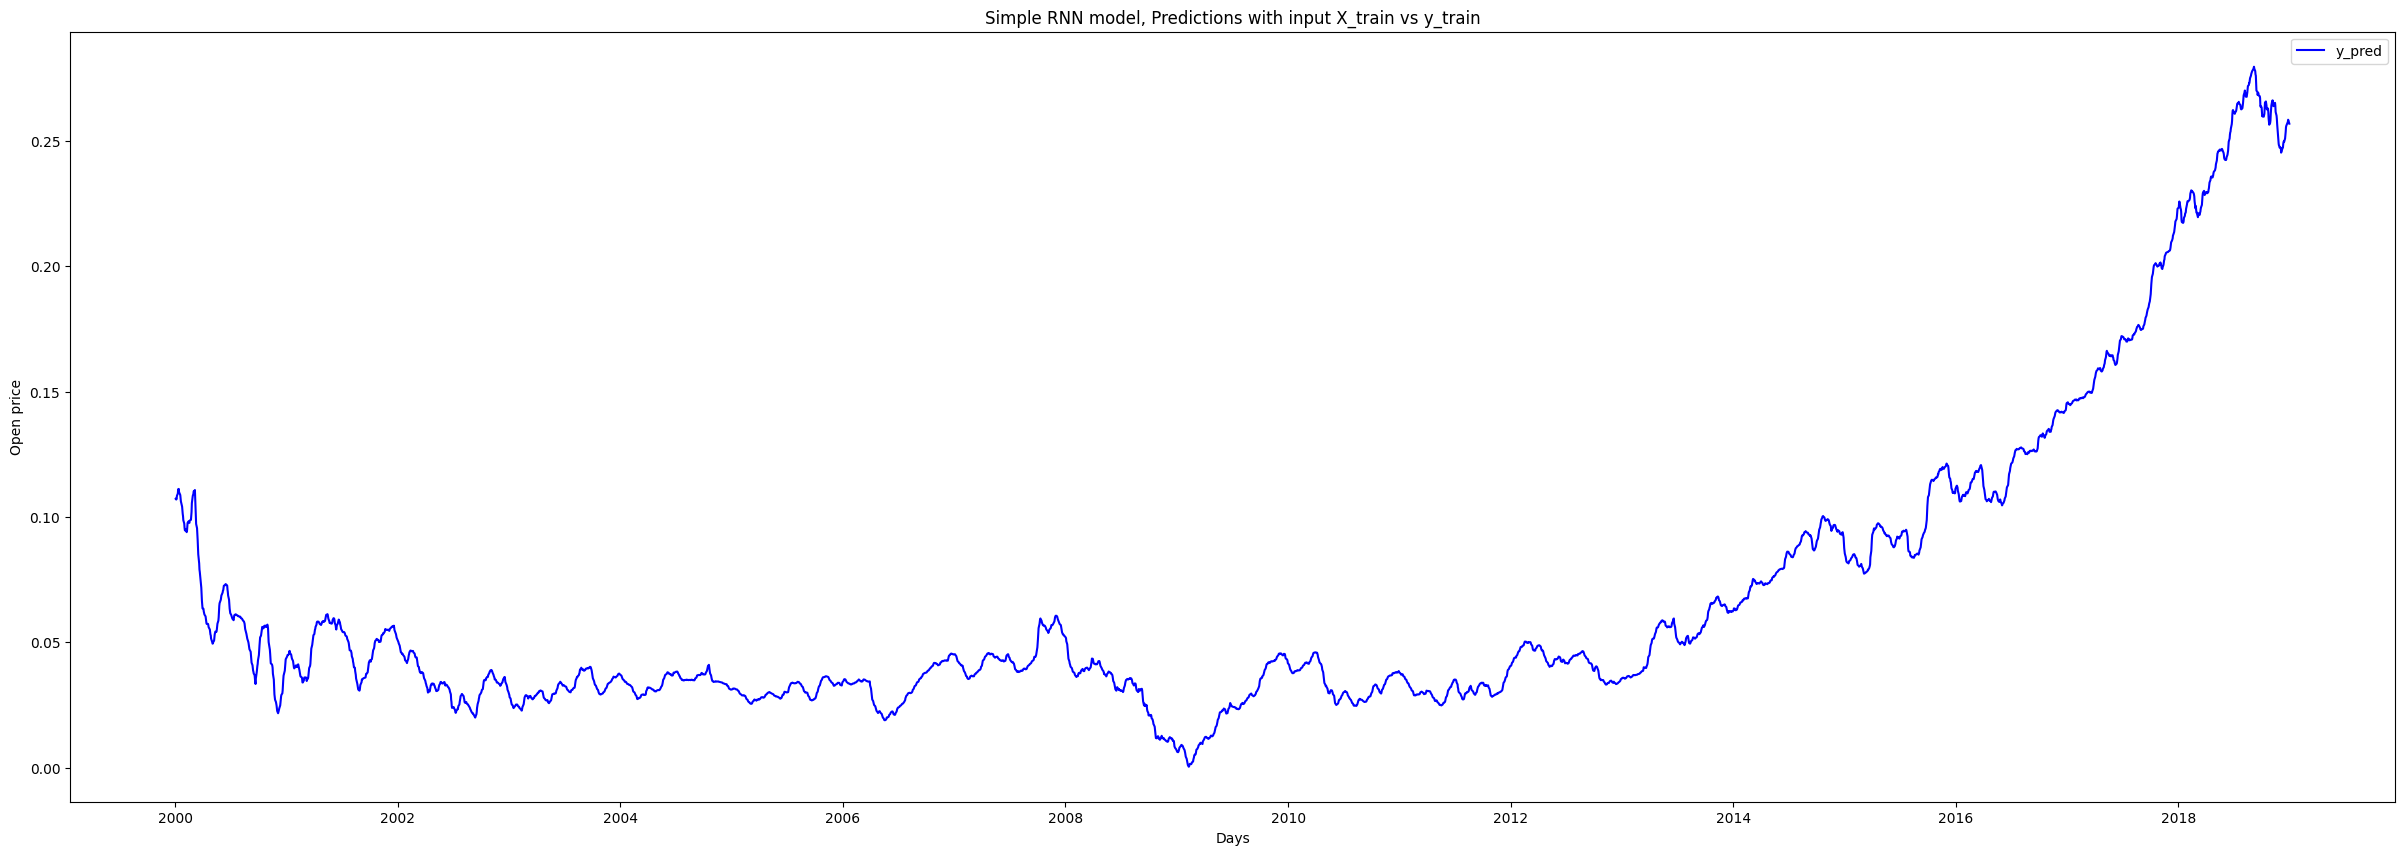

In [135]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(df1.index[:training_size-20:],train_predict, color = "b", label = "y_pred" )
# plt.plot(y_train, color = "r", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [120]:
df1.index.shape

(5999,)

In [133]:
df1.index[:training_size-20:].shape

(4779,)

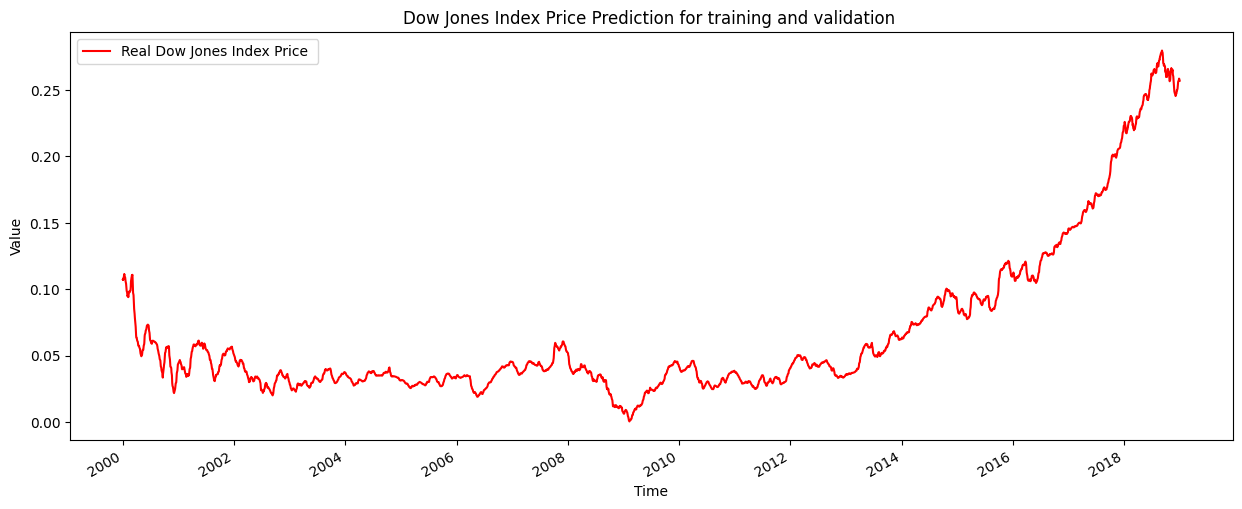

In [134]:
figure, axes = plt.subplots(figsize=(15, 6))


axes.plot(df1.index[:training_size-20:], train_predict, color = 'red', label = 'Real Dow Jones Index Price ')
# axes.plot(X_bigtrain_raw.index[seq:], y_pred, color = 'blue', label = 'Predicted Dow Jones Index Price ')

plt.title('Dow Jones Index Price Prediction for training and validation ')
# plt.axvline(x = X_bigtrain_raw.index[len(X_train_seq)+seq], color = 'g', label = 'training data cutoff')
plt.xlabel('Time')
plt.ylabel('Value')
plt.gcf().autofmt_xdate()
plt.legend()

plt.show()